**Task 1: Carnivores Image Classification**

**AIM :** To train a simple Convolutional Neural Network (CNN) to classify Carnivores images.

**CNN**

A Convolutional Neural Network (CNN) is the foundation of most computer vision technologies. Unlike traditional multilayer perceptron architectures, it uses two operations called ‘convolution’ and pooling’ to reduce an image into its essential features, and uses those features to understand and classify the image.

**Load Data from Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path='/content/drive/MyDrive/carnivores-20220903T053339Z-001/carnivores/train'
test_path='/content/drive/MyDrive/carnivores-20220903T053339Z-001/carnivores/test'

**Importing Packages**

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import math
import warnings
warnings.filterwarnings("ignore")

**Pre-trained CNN Model as a Feature Extractor**

In [ ]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model,load_model
conv_base =  InceptionV3(weights='imagenet',include_top=False,
                         input_shape=(300, 300, 3))
output = conv_base.layers[-1].output
output = keras.layers.Flatten()(output)
model_tl = Model(conv_base.input, output)
model_tl.trainable = False
for layer in model_tl.layers:
    layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in  
               model_tl.layers]
model_layers=pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
print(model_layers) 

87924736/87910968 [==============================] - 0s 0us/step
                                            Layer Type           Layer Name  \
0    <keras.engine.input_layer.InputLayer object at...              input_1   
1    <keras.layers.convolutional.Conv2D object at 0...               conv2d   
2    <keras.layers.normalization.batch_normalizatio...  batch_normalization   
3    <keras.layers.core.activation.Activation objec...           activation   
4    <keras.layers.convolutional.Conv2D object at 0...             conv2d_1   
..                                                 ...                  ...   
307  <keras.layers.merge.Concatenate object at 0x7f...             mixed9_1   
308  <keras.layers.merge.Concatenate object at 0x7f...        concatenate_1   
309  <keras.layers.core.activation.Activation objec...        activation_93   
310  <keras.layers.merge.Concatenate object at 0x7f...              mixed10   
311  <keras.layers.core.flatten.Flatten object at 0...            

**Data Pre-processing and Data Augmentation**

**Data Augmentation**

It is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Training deep learning neural network models on more data can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
test_size=400
batch_size=32
epochs=25
train_path='/content/drive/MyDrive/carnivores-20220903T053339Z-001/carnivores/train'
test_path='/content/drive/MyDrive/carnivores-20220903T053339Z-001/carnivores/test'
target_size=(300,300) #resize all images to 300x300
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,  
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range = [0.8, 1.2],
                                   fill_mode='nearest',        
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
                  train_path,
                  target_size=target_size,#  
                  batch_size=batch_size,
                  class_mode='categorical',
                  subset='training')
validation_generator = train_datagen.flow_from_directory(
                       train_path,
                       target_size=target_size,
                       batch_size=batch_size,
                       class_mode='categorical',
                       subset='validation')

Found 2883 images belonging to 4 classes.
Found 720 images belonging to 4 classes.


**Building Model Architecture**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras import optimizers
# building a linear stack of layers with the sequential model
model =Sequential()
model.add(model_tl)
# hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(4, activation='softmax'))
# compiling the sequential model
model.compile(loss='categorical_crossentropy',
              
              metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 131072)            21802784  
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 38,580,644
Trainable params: 16,777,860
Non-trainable params: 21,802,784
_________________________________________________________________
None


**Saving Model Checkpoints**

In [ ]:
from keras.callbacks import *
filepath="/content/drive/My Drive/MyCNN/epochs:{epoch:03d}-val_acc: {val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             verbose=1,
                             save_best_only=False,
                             save_freq='epoch',     
                             mode='max')
callbacks_list = [checkpoint]

**Training Model**

In [ ]:
history = model.fit(
          train_generator,
          steps_per_epoch=train_generator.samples//batch_size,    
          validation_data=validation_generator,
          validation_steps=validation_generator.samples//batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks=callbacks_list)

**Model Performance**

In [ ]:
# Model evaluation

scores_train = model.evaluate(train_generator,verbose=1)
scores_validation = model.evaluate(validation_generator,verbose=1)
print("Train Accuracy: %.2f%%" % (scores_train[1]*100))
print("Validation Accuracy: %.2f%%" % (scores_validation[1]*100))

#For plotting Accuracy and Loss

def LearningCurve(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

LearningCurve(history)

#Save the trained model to a file 

model_weight_file='/content/drive/MyDrive/MyCNN/carnivores_tlearn_img_aug_cnn.h5'
model.save(model_weight_file)

23/23 [==============================] - 256s 11s/step - loss: 64.7590 - acc: 0.2958
Train Accuracy: 28.82%
Validation Accuracy: 29.58%


NameError: ignored

**Making Predictions**

Found 400 images belonging to 4 classes.
13/13 [==============================] - 101s 8s/step
[[ 97   2   1   0]
 [  0 100   0   0]
 [  2   0  98   0]
 [  0   0   0 100]]
              precision    recall  f1-score   support

     cheetah       0.98      0.97      0.97       100
       hyena       0.98      1.00      0.99       100
      jaguar       0.99      0.98      0.98       100
       tiger       1.00      1.00      1.00       100

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



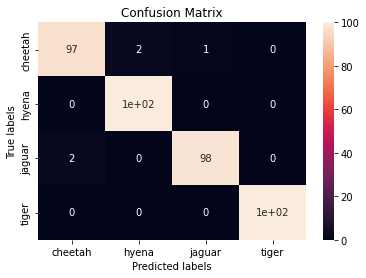

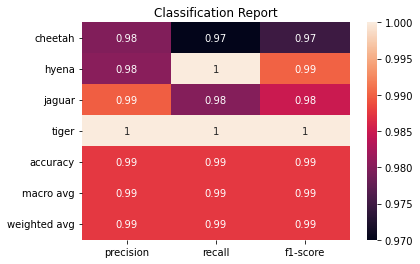

In [ ]:
# We take the ceiling because we do not drop the remainder of the batch

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

test_steps = compute_steps_per_epoch(test_size)

test_generator = test_datagen.flow_from_directory(
                 test_path,
                 target_size=target_size, 
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)

test_generator.reset()

#Calling the saved model for making predictions
tl_img_aug_cnn = load_model(model_weight_file)

pred=tl_img_aug_cnn.predict(test_generator,
                            verbose=1,
                            steps=test_steps)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

#create a function for visualizing model performance

import seaborn as sns

def PerformanceReports(conf_matrix,class_report,labels):
    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True,ax=ax)
    #labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T,  
                annot=True,ax=ax)
    ax.set_title('Classification Report')
    plt.show()

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

labels=['cheetah','hyena','jaguar','tiger']
test_labels = [fn.split('/')[0] for fn in filenames]

cm=confusion_matrix(test_labels,predictions)
print(cm)

cr=classification_report(test_labels, predictions)
class_report=classification_report(test_labels, predictions,
                                   target_names=labels,
                                   output_dict=True)

print(cr)

PerformanceReports(cm,class_report,labels)

**Conclusion:**
We can see that our model has a training accuracy of 98.82% and validation accuracy of 97.78%. The train and validation accuracy are quite close to each other, indicating that the model is a good fit.